In [1]:
# %%
# !pip install DeepMIMO==4.0.0b10

# %%
# %%
# =============================================================================
# 1. IMPORTS AND WARNINGS SETUP
#    - Load necessary PyTorch modules, utilities, and suppress UserWarnings
# =============================================================================
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.optim.lr_scheduler import ReduceLROnPlateau
import os
import torch
from tqdm import tqdm
import math
# from utils import (generate_channels_and_labels, tokenizer_train, tokenizer, make_sample, nmse_loss,
                #    create_train_dataloader, patch_maker, count_parameters, train_lwm)
from collections import defaultdict
import numpy as np
# import pretrained_model  # Assuming this contains the LWM model definition
import matplotlib.pyplot as plt
import warnings
import os
import bisect
# from collections import defaultdict
from tqdm import tqdm
warnings.filterwarnings("ignore", category=UserWarning)
# from utils import *
import deepmimo as dm
from sklearn.metrics import mean_squared_error
import numpy as np
from tqdm import tqdm
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
from models import GPTPathDecoder
from dataset.dataloaders import MySeqDataLoader
from utils.utils import *

/home/johnny/.venv/lib/python3.12/site-packages/torch/cuda/__init__.py:63: FutureWarning: The pynvml package is deprecated. Please install nvidia-ml-py instead. If you did not install pynvml directly, please report this to the maintainers of the package that installed pynvml for you.
  import pynvml  # type: ignore[import]


In [2]:
# scenario = 'city_0_newyork_3p5_lwm'
# row_column_users = {
#     'n_rows': 109,
#     'n_per_row': 291,
#     'grid_idx': 1,
#     'n_ant_bs': 8,
#     'n_subcarriers': 32
# }
# dm.download(scenario)
# dataset = dm.load(scenario,)
# # dataset.compute_channels()
# def get_parameters(num_ant_hor=32, num_ant_vert=1, n_subcarriers=32):
#     """
#     Generate channel parameters for DeepMIMO dataset generation.

#     Args:
#         num_ant_hor (int): Number of horizontal antennas at the base station. Defaults to 32.
#         num_ant_vert (int): Number of vertical antennas at the base station. Defaults to 1.
#         n_subcarriers (int): Number of subcarriers per channel. Defaults to 32.
#         bs_idx (int): Index of the base station. Defaults to 1.

#     Returns:
#         dm.ChannelGenParameters: Configured channel parameters object for DeepMIMO data generation.
#     """
#     # Create channel parameters with all options
#     ch_params = dm.ChannelParameters()

#     # Antenna parameters

#     # Base station antenna parameters
#     ch_params.bs_antenna.rotation = np.array([0, 0, -135])  # [az, el, pol] in degrees
#     ch_params.bs_antenna.fov = np.array([360, 180])      # [az, el] in degrees
#     ch_params.bs_antenna.shape = np.array([num_ant_hor, num_ant_vert])        # [horizontal, vertical] elements
#     ch_params.bs_antenna.spacing = 0.5                   # Element spacing in wavelengths

#     # User equipment antenna parameters
#     ch_params.ue_antenna.rotation = np.array([0, 0, 0])  # [az, el, pol] in degrees
#     ch_params.ue_antenna.fov = np.array([360, 180])      # [az, el] in degrees
#     ch_params.ue_antenna.shape = np.array([1, 1])        # [horizontal, vertical] elements
#     ch_params.ue_antenna.spacing = 0.5                   # Element spacing in wavelengths
    
#     # Channel parameters
#     ch_params.freq_domain = True  # Whether to compute frequency domain channels
#     ch_params.num_paths = 20      # Number of paths

#     # OFDM parameters
#     subcarrier_spacing = 30e3                                 
#     ch_params.ofdm.subcarriers = n_subcarriers                       # Number of subcarriers
#     ch_params.ofdm.selected_subcarriers = np.arange(n_subcarriers)   # Which subcarriers to generate
#     ch_params.ofdm.bandwidth = subcarrier_spacing * n_subcarriers    # Bandwidth in Hz
#     ch_params.ofdm.rx_filter = 0     
    
#     return ch_params

# parameters = get_parameters(8, 1, 32)
# channels = dataset.compute_channels(parameters)*


Scenario "city_0_newyork_3p5" already exists in /home/johnny/bless/PathFormer/deepmimo_scenarios
Loading TXRX PAIR: TXset 1 (tx_idx 0) & RXset 0 (rx_idxs 31719)
Loading TXRX PAIR: TXset 2 (tx_idx 0) & RXset 0 (rx_idxs 31719)
Loading TXRX PAIR: TXset 3 (tx_idx 0) & RXset 0 (rx_idxs 31719)

Fundamental Matrices:
power: Tap power. Received power in dBW for each path, assuming 0 dBW transmitted power. 
10*log10(|a|²), where a is the complex channel amplitude
	[num_rx, num_paths]
phase: Tap phase. Phase of received signal for each path in degrees. 
∠a (angle of a), where a is the complex channel amplitude
	[num_rx, num_paths]
delay: Tap delay. Propagation delay for each path in seconds
	[num_rx, num_paths]
aoa_az: Angle of arrival (azimuth) for each path in degrees
	[num_rx, num_paths]
aoa_el: Angle of arrival (elevation) for each path in degrees
	[num_rx, num_paths]
aod_az: Angle of departure (azimuth) for each path in degrees
	[num_rx, num_paths]
aod_el: Angle of departure (elevation) for

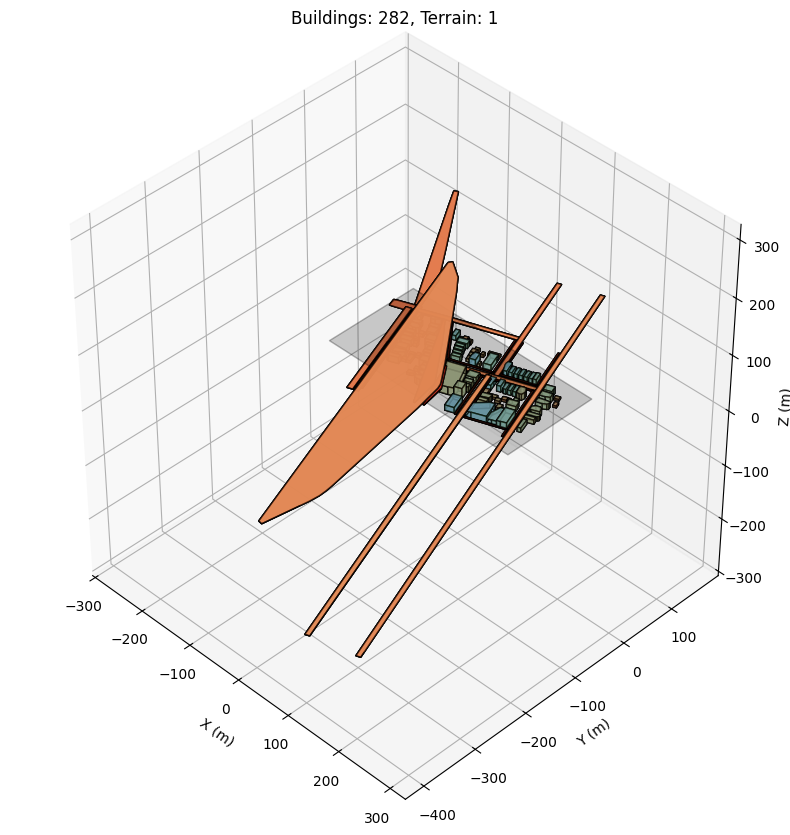

In [3]:
# %%
# scenario = 'city_89_nairobi_3p5'
scenario = 'city_0_newyork_3p5'

dm.download(scenario)
dataset = dm.load(scenario, )

# %%
dataset.scene.plot()


# %%
dm.info()


# %%
config = {
    "BATCH_SIZE":64,
    "PAD_VALUE": 500,
    "USE_WANDB": False,
    "LR":2e-7,
    "task": "channel_estimation",
    "epochs" : 20,
    "interaction_weight": 0.01,  # Weight for interaction loss
    "experiment": f"{scenario}_interacaction_all_inter_str_dec_all_aod"
}


# %%
train_data  = MySeqDataLoader(dataset, train=True, split_by="user", sort_by="power")

train_loader = torch.utils.data.DataLoader(
    dataset     = train_data,
    batch_size  = config['BATCH_SIZE'],
    shuffle     = True,
    collate_fn= train_data.collate_fn
    )
val_data  = MySeqDataLoader(dataset, train=False, split_by="user", sort_by="power")
val_loader = torch.utils.data.DataLoader(
    dataset     = val_data,
    batch_size  = config['BATCH_SIZE'],
    shuffle     = False,
    collate_fn= val_data.collate_fn
    )

for item in train_loader:
    print(f"Prompt shape: {item[0].shape}, Paths shape: {item[1].shape}, Num paths shape: {item[2].shape}")
    
    break


# %%
print("No. of Train Points   : ", train_data.__len__())
print("Batch Size           : ", config["BATCH_SIZE"])
print("Train Batches        : ", train_loader.__len__())
print("No. of Train Points   : ", val_data.__len__())
print("Val Batches          : ", val_loader.__len__())

# %%



In [22]:




def evaluate_model(model, val_loader, max_generate=26, log_to_wandb=False):
    model.eval()

    delay_errors = []
    power_errors = []
    phase_errors = []
    path_length_rmses = []



    delay_maes = []
    power_maes = []
    phase_maes = []
    path_length_maes = []
    

    # AoA metrics
    az_errors = []
    ch_nmse_errors = []
    raw_ch_nmses = []
    el_errors = []
    az_maes = []
    el_maes = []
    with torch.no_grad():
        outer_bar = tqdm(val_loader, desc="Evaluating (batches)", leave=True)

        for prompts, paths, path_lengths,interactions in outer_bar:
            prompts = prompts.cuda()
            paths = paths.cuda()
            path_lengths = path_lengths.cuda()
         
            # Inner tqdm to show per-sample progress
            inner_bar = tqdm(range(prompts.size(0)), 
                             desc="   Processing samples", 
                             leave=False)

            
            for b in inner_bar:
                generated, path_lengths_pred, inter_str_pred = generate_paths(model, prompts[b], max_steps=max_generate)

                generated = generated.cuda()
                # ground truth: delay, power, phase, aoa_az, aoa_el
                gt = paths[b][1:, :5]

                # Mask padded values
                valid_mask = (gt[:,0] != train_data.pad_value)
                gt = gt[valid_mask]
                # print(valid_mask)
                T = min(len(gt), len(generated))
                pred = generated[:T]
                gt = gt[:T]

                # ---- Compute Metrics ----
                delay_rmse = torch.mean((pred[:,0] - gt[:,0])**2).sqrt().item()
                delay_mae = torch.mean(torch.abs(pred[:,0] - gt[:,0])).item()

                power_rmse = torch.mean((pred[:,1]/0.01 - gt[:,1]/0.01)**2).sqrt().item()
                power_mae = torch.mean((torch.abs(pred[:,1]/0.01 - gt[:,1]/0.01))).item()


                # Phase errors
                y_hat_angles = (pred[:,2] / (np.pi/180))
                y_angles = (gt[:,2] / (np.pi/180))
                phase_circular_dist = (y_hat_angles - y_angles + 180) % 360 - 180
                phase_rmse = torch.mean(phase_circular_dist**2).sqrt().item()
                phase_mae = torch.mean(torch.abs(phase_circular_dist)).item()

                # AoA azimuth errors
                y_hat_az = (pred[:,3] / (np.pi/180))
                y_az = (gt[:,3] / (np.pi/180))
                az_circular_dist = (y_hat_az - y_az + 180) % 360 - 180
                az_rmse = torch.mean(az_circular_dist**2).sqrt().item()
                az_mae = torch.mean(torch.abs(az_circular_dist)).item()

                # AoA elevation errors
                y_hat_el = (pred[:,4] / (np.pi/180))
                y_el = (gt[:,4] / (np.pi/180))
                el_circular_dist = (y_hat_el - y_el + 180) % 360 - 180
                el_rmse = torch.mean(el_circular_dist**2).sqrt().item()
                el_mae = torch.mean(torch.abs(el_circular_dist)).item()

                # Path length RMSE
                # print(path_lengths_pred, path_lengths[b],)
                length_rmse = (torch.mean( (path_lengths_pred - path_lengths[b])**2)).sqrt().item()
                length_mae = (torch.mean(torch.abs(path_lengths_pred - path_lengths[b]))).item()

                power_pred = np.expand_dims(pred[:,1].cpu().numpy(),0)
                delay_pred = np.expand_dims(pred[:,0].cpu().numpy(),0)

                pred_power_linear = 10**( ((power_pred)/0.01)/10)
                pred_delay_secs = delay_pred/ 1e6


                delay_t = np.expand_dims(gt[:, 0].cpu().numpy(),0)
                power_t = np.expand_dims(gt[:, 1].cpu().numpy(),0)
                phase = np.expand_dims(gt[:, 2].cpu().numpy(),0)
                az = np.expand_dims(gt[:, 3].cpu().numpy(),0)
                el = np.expand_dims(gt[:, 4].cpu().numpy(),0)

                power_t = np.where(power_t==config["PAD_VALUE"], 0, power_t)
                power_linear = 10**( (power_t/0.01)/10)

                phase_pred = np.expand_dims( pred[:,2].cpu().numpy(),0)
                az_pred = np.expand_dims(pred[:,3].cpu().numpy(),0)
                el_pred = np.expand_dims(pred[:,4].cpu().numpy(),0)

                delay_secs = delay_t/ 1e6
                mask= delay_secs == config["PAD_VALUE"]/ 1e6
                delay_secs = np.where(mask, np.nan, delay_secs)
                phase = np.where(mask, np.nan, phase)
                pred_delay_secs = np.where(mask, np.nan, pred_delay_secs)
                pred_power_linear = np.where(mask, np.nan, pred_power_linear)
                phase_pred = np.where(mask, np.nan, phase_pred)
                az_pred = np.where(mask, np.nan, az_pred)
                el_pred = np.where(mask, np.nan, el_pred)


                power_linear = np.where(mask, np.nan, power_linear)
                phase = np.where(mask, np.nan, phase)
                az = np.where(mask, np.nan, az)
                el = np.where(mask, np.nan, el)


                
                
                predicted_channels = mycomputer.compute_channels(pred_power_linear,pred_delay_secs, phase_pred, az_pred, el_pred,kwargs=None  )
                gt_channels = mycomputer.compute_channels(power_linear,delay_secs, phase, az, el ,kwargs=None )

            


                ch_nmse = compute_channel_nmse(predicted_channels, gt_channels)
                
                db_min, db_max = -20.0, 0.0
                normalized = (ch_nmse - db_min) / (db_max - db_min)
                score = 1.0 - normalized
                ch_score = max(0.0, min(1.0, score))

                raw_ch_nmses.append(ch_nmse)
                ch_nmse_errors.append(ch_score)
                # Save metrics
                delay_errors.append(delay_rmse)
                power_errors.append(power_rmse)
                phase_errors.append(phase_rmse)
                path_length_rmses.append(length_rmse)
                # AoA
                az_errors.append(az_rmse)
                el_errors.append(el_rmse)

                delay_maes.append(delay_mae)
                power_maes.append(power_mae)
                phase_maes.append(phase_mae)
                path_length_maes.append(length_mae)
                az_maes.append(az_mae)
                el_maes.append(el_mae)
                # Show live metric values in tqdm
                inner_bar.set_postfix({
                    "delay_rmse": f"{delay_rmse:.3f}",
                    "power_rmse": f"{power_rmse:.3f}",
                    "phase_rmse": f"{phase_rmse:.3f}",
                    "az_rmse": f"{az_rmse:.3f}",
                    "el_rmse": f"{el_rmse:.3f}",
                    "ch_nmse": f"{ch_nmse:.3f}",
                    "ch_score": f"{ch_score:.3f}",
                    "length_rmse": f"{length_rmse:.3f}",
                    "delay_mae": f"{delay_mae:.3f}",
                    "power_mae": f"{power_mae:.3f}",
                    "phase_mae": f"{phase_mae:.3f}",
                    "az_mae": f"{az_mae:.3f}",
                    "el_mae": f"{el_mae:.3f}",
                    "length_mae": f"{length_mae:.3f}"
                })

                # wandb logging
                if log_to_wandb:
                    wandb.log({
                        "test_delay_rmse": delay_rmse,
                        "test_power_rmse": power_rmse,
                        "test_phase_circ_err": phase_rmse,
                        "test_stop_length_rmse": length_rmse,
                        "test_az_rmse": az_rmse,
                        "test_el_rmse": el_rmse,
                        "test_delay_mae": delay_mae,
                        "test_power_mae": power_mae,
                        "test_phase_circ_err_mae": phase_mae,
                        "test_az_mae": az_mae,
                        "test_el_mae": el_mae,
                        "test_stop_length_mae": length_mae,
                    })
            # print("Batch evaluation complete.")
            
            # print("\n================= Up toBATCH EVALUATION RESULTS =================")
            # print(f"Avg Delay RMSE           : {np.mean(delay_errors):.4f} µs")
            # print(f"Avg Power RMSE           : {np.mean(power_errors):.4f} dB")
            # print(f"Avg Phase RMSE           : {np.mean(phase_errors):.4f} degrees")
            # print(f"Avg Path Length RMSE     : {np.mean(path_length_rmses):.4f}")
            # print(f"Avg ch_score_nsme    : {np.mean(ch_nmse_errors):.4f}")

            # print(f"Avg Delay MAE           : {np.mean(delay_maes):.4f} µs")
            # print(f"Avg Power MAE           : {np.mean(power_maes):.4f} dB")
            # print(f"Avg Phase MAE           : {np.mean(phase_maes):.4f} degrees")
            # print(f"Avg Path Length MAE     : {np.mean(path_length_maes):.4f}")
            # print("============================================================")
            

    # ---- Final Aggregated Results ----
    avg_delay = np.mean(delay_errors)
    avg_power = np.mean(power_errors)
    avg_phase = np.mean(phase_errors)
    avg_az = np.mean(az_errors) if len(az_errors) > 0 else 0.0
    avg_el = np.mean(el_errors) if len(el_errors) > 0 else 0.0
    avg_path_length_rmse = np.mean(path_length_rmses)
    avg_ch_score = np.mean(ch_nmse_errors)
    avg_ch_nmse= np.mean(raw_ch_nmses)

    avg_delay_mae = np.mean(delay_maes)
    avg_power_mae = np.mean(power_maes)
    avg_phase_mae = np.mean(phase_maes)
    avg_path_length_mae= np.mean(path_length_maes)

    print("\n=================  Final EVALUATION RESULTS =================")
    print(f"Delay RMSE           : {avg_delay:.4f} µs")
    print(f"Power RMSE           : {avg_power:.4f} dB")
    print(f"Phase RMSE           : {avg_phase:.4f} degrees")
    print(f"AoA Azimuth RMSE     : {avg_az:.4f} degrees")
    print(f"AoA Elevation RMSE   : {avg_el:.4f} degrees")
    print(f"Path Length RMSE     : {avg_path_length_rmse:.4f}")
    print(f"avg_ch_score        :       {avg_ch_score:.4f}") 
    print(f"avg_ch_nmse          :       {avg_ch_nmse:.4f}")   
    print(f"Delay MAE           : {avg_delay_mae:.4f} µs")
    print(f"Power MAE           : {avg_power_mae:.4f} dB")
    print(f"Phase MAE           : {avg_phase_mae:.4f} degrees")
    print(f"AoA Azimuth MAE     : {np.mean(az_maes) if len(az_maes)>0 else 0.0:.4f} degrees")
    print(f"AoA Elevation MAE   : {np.mean(el_maes) if len(el_maes)>0 else 0.0:.4f} degrees")
    print(f"Path Length MAE     : {avg_path_length_mae:.4f}")
    print("=====================================================\n")

    if log_to_wandb:
        wandb.run.summary["test_delay_rmse"] = avg_delay
        wandb.run.summary["test_power_rmse"] = avg_power
        wandb.run.summary["test_phase_circ_err"] = avg_phase
        wandb.run.summary["test_path_length_rmse"] = avg_path_length_rmse
        
        wandb.run.summary["test_delay_mae"] = avg_delay_mae
        wandb.run.summary["test_power_mae"] = avg_power_mae
        wandb.run.summary["test_phase_circ_err_mae"] = avg_phase_mae
        wandb.run.summary["test_path_length_mae"] = avg_path_length_mae

    return avg_delay, avg_power, avg_phase, avg_az, avg_el, avg_path_length_rmse, avg_delay_mae, avg_power_mae, avg_phase_mae, avg_path_length_mae 



device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# model = PathDecoder().to(device)
model = GPTPathDecoder().to(device)

print("Total trainable parameters:", count_parameters(model))


# %%
if config["USE_WANDB"]:
    import wandb

    wandb.init(
        project="deepmimo-path-decoder",
        config = config
        # config={
        #     "batch_size": train_loader.batch_size,
        #     "split_type": train_data.split_by,
        # }
    )


# %%


optimizer = torch.optim.AdamW(model.parameters(), lr=config["LR"])
# scheduler = ReduceLROnPlateau(optimizer, factor=0.5, patience=2, mode="min")
scheduler = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(
    optimizer, 
    T_0=25,      # Restart every 10 epochs
    T_mult=1,    # Double the period after each restart
    eta_min=1e-8 # Minimum LR
)

# Initialize best checkpoint tracking (based on path_length loss)

# scheduler = ReduceLROnPlateau(optimizer, factor=0.5, patience=2, mode="min")
mycomputer = MyChannelComputer()
checkpoint_path = f"{config['experiment']}_best_model_checkpoint.pth"
os.makedirs("checkpoints2", exist_ok=True)
checkpoint_path = os.path.join("checkpoints2", checkpoint_path)
os.makedirs("checkpoints_channel", exist_ok=True)
checkpoint_finetune = f"{config['task']}_{config['experiment']}_best_model_checkpoint.pth"
checkpoint_finetune_path = os.path.join("checkpoints_channel", checkpoint_finetune)


def task_finetune(model, train_loader, val_loader, config, train_data, task):
    """
    Modified training loop with interaction prediction.
    """

    best_val_loss = float('inf')


    for epoch in range(config["epochs"]):
        # -------------------- TRAINING --------------------
        model.train()
        train_losses = []
        train_loss_delay = []
        train_loss_power = []
        train_loss_phase = []
        train_loss_path_length = []
        train_loss_interaction = []  # NEW
        train_path_length_rmse = []
        train_loss_az = []
        train_loss_el = []
        train_ch_nmse = []
        train_ch_loss = []
        pbar = tqdm(train_loader, desc=f"Epoch {epoch} [Train]", leave=False)
        for prompts, paths, path_lengths, interactions in pbar:  # NEW: added interactions
            prompts = prompts.cuda()
            paths = paths.cuda()
            path_lengths = path_lengths.cuda()
            interactions = interactions.cuda()  # NEW
            
            paths_in = paths[:, :-1, :]
            interactions_in = interactions[:, :-1, :]

            paths_out = paths[:, 1:, :]
            interactions_out = interactions[:, 1:, :]  # NEW: shift targets

            (delay_pred, power_pred, phase_sin_pred, phase_cos_pred, phase_pred,
             az_sin_pred, az_cos_pred, az_pred, el_sin_pred, el_cos_pred, el_pred,
             path_length_pred, interaction_logits) = model(prompts, paths_in, interactions_in)

            (total_loss, loss_delay, loss_power, loss_phase,
             loss_az, loss_el, loss_path_length, loss_interaction,loss_channel) = masked_loss(
                delay_pred, power_pred, phase_sin_pred, phase_cos_pred,phase_pred,
                az_sin_pred, az_cos_pred, az_pred, el_sin_pred, el_cos_pred,el_pred,
                path_length_pred, interaction_logits, paths_out, path_lengths,
                interactions_out, finetune=task, pad_value=train_data.pad_value,
                interaction_weight=config.get("interaction_weight", 0.1)
            )
            optimizer.zero_grad()
            total_loss.backward()
            optimizer.step()
            scheduler.step()
           
            # path_length_rmse = compute_stop_metrics(path_length_pred.detach().squeeze(-1), 
            #                                         path_lengths)
            path_length_rmse = 0
            # ch_nmse = 0
            # if epoch >= 0:
            pred_power_linear = 10**( ((power_pred.cpu().detach().numpy())/0.01)/10)
            pred_delay_secs = delay_pred.cpu().detach().numpy()/ 1e6


            delay_t = paths_out[:, :, 0].cpu().detach().numpy()
            power_t = paths_out[:, :, 1].cpu().detach().numpy()
            phase = paths_out[:, :, 2].cpu().detach().numpy()
            phase = np.rad2deg(phase)
            az = paths_out[:, :, 3].cpu().detach().numpy()
            el = paths_out[:, :, 4].cpu().detach().numpy()
            power_t = np.where(power_t==config["PAD_VALUE"], 0, power_t)
            power_linear = 10**( (power_t/0.01)/10)

            phase_pred = phase_pred.cpu().detach().numpy()
            phase_pred = np.rad2deg(phase_pred)
            az_pred = az_pred.cpu().detach().numpy()
            el_pred = el_pred.cpu().detach().numpy()

            delay_secs = delay_t/ 1e6
            mask= delay_secs == config["PAD_VALUE"]/ 1e6
            delay_secs = np.where(mask, np.nan, delay_secs)
            phase = np.where(mask, np.nan, phase)
            pred_delay_secs = np.where(mask, np.nan, pred_delay_secs)
            pred_power_linear = np.where(mask, np.nan, pred_power_linear)
            phase_pred = np.where(mask, np.nan, phase_pred)
            az_pred = np.where(mask, np.nan, az_pred)
            el_pred = np.where(mask, np.nan, el_pred)


            power_linear = np.where(mask, np.nan, power_linear)
            phase = np.where(mask, np.nan, phase)
            az = np.where(mask, np.nan, az)
            el = np.where(mask, np.nan, el)


            
            
            gt_channels = mycomputer.compute_channels(power_linear,delay_secs, phase, az, el ,kwargs=None )
            predicted_channels = mycomputer.compute_channels(pred_power_linear,pred_delay_secs, phase_pred, az_pred, el_pred,kwargs=None  )
            # print("Numpy", phase_pred[0])


            ch_nmse = compute_channel_nmse(predicted_channels, gt_channels)
            train_ch_nmse.append(ch_nmse)
            train_ch_loss.append(loss_channel.item())
            train_losses.append(total_loss.item())
            train_loss_delay.append(loss_delay.item())
            train_loss_power.append(loss_power.item())
            train_loss_phase.append(loss_phase.item())
            train_loss_path_length.append(loss_path_length.item())
            # track aoa losses
            # if 'train_loss_az' not in locals():
            #     train_loss_az = []
            #     train_loss_el = []
            train_loss_az.append(loss_az.item())
            train_loss_el.append(loss_el.item())
            train_loss_interaction.append(loss_interaction.item())  # NEW
            train_path_length_rmse.append(path_length_rmse)
            current_lr = optimizer.param_groups[0]["lr"]
            pbar.set_postfix({
                "loss": f"{total_loss.item():.4f}",
                "delay": f"{loss_delay.item():.4f}",
                "ch_loss":f"{loss_channel.item():.4f}",
                "power": f"{loss_power.item():.4f}",
                "phase": f"{loss_phase.item():.4f}",
                "az": f"{loss_az.item():.4f}",
                "el": f"{loss_el.item():.4f}",
                "inter": f"{loss_interaction.item():.4f}",  # NEW
                "path_rmse": f"{path_length_rmse:.4f}",
                "ch_nmse":f"{ch_nmse:.4f}",
                "lr": f"{current_lr:.2e}"
            })
        # print("pred_channel",predicted_channels[0])
        # print("gt_channel",gt_channels[0])

        avg_train_loss = np.mean(train_losses)
        avg_train_delay = np.mean(train_loss_delay)
        avg_train_power = np.mean(train_loss_power)
        avg_train_phase = np.mean(train_loss_phase)
        avg_train_az = np.mean(train_loss_az) 
        avg_train_el = np.mean(train_loss_el)
        avg_train_ch_nmse = np.mean(train_ch_nmse)
        avg_train_ch_loss = np.mean(train_ch_loss)

        avg_train_path_length = np.mean(train_loss_path_length)
        avg_train_interaction = np.mean(train_loss_interaction)  # NEW
        avg_train_path_length_rmse = np.mean(train_path_length_rmse)
        # print("")
        # -------------------- VALIDATION --------------------
        model.eval()
        val_losses = []
        val_loss_delay = []
        val_loss_power = []
        val_loss_phase = []
        val_loss_path_length = []
        val_loss_interaction = []  # NEW
        val_path_length_rmse = []
        val_ch_nmse = []
        val_ch_loss = []
        with torch.no_grad():
            pbar = tqdm(val_loader, desc=f"Epoch {epoch} [Val]", leave=False)
            # prepare val aoa loss lists
            val_loss_az = []
            val_loss_el = []
            for prompts, paths, path_lengths, interactions in pbar:  # NEW
                prompts = prompts.cuda()
                paths = paths.cuda()
                path_lengths = path_lengths.cuda()
                interactions = interactions.cuda()  # NEW

                paths_in = paths[:, :-1, :]
                interactions_in = interactions[:, :-1, :]

                paths_out = paths[:, 1:, :]
                interactions_out = interactions[:, 1:, :]  # NEW: shift targets

                (delay_pred, power_pred, phase_sin_pred, phase_cos_pred, phase_pred,
                 az_sin_pred, az_cos_pred, az_pred, el_sin_pred, el_cos_pred, el_pred,
                 path_length_pred, interaction_logits) = model(prompts, paths_in, interactions_in)

                (total_loss, loss_delay, loss_power, loss_phase,
                loss_az, loss_el, loss_path_length, loss_interaction,loss_channel) = masked_loss(
                    delay_pred, power_pred, phase_sin_pred, phase_cos_pred,phase_pred,
                    az_sin_pred, az_cos_pred, az_pred, el_sin_pred, el_cos_pred,el_pred,
                    path_length_pred, interaction_logits, paths_out, path_lengths,
                    interactions_out, finetune="channel_estimation", pad_value=train_data.pad_value,
                    interaction_weight=config.get("interaction_weight", 0.1)
                )
                # path_length_rmse = compute_stop_metrics(path_length_pred.detach().squeeze(-1), 
                #                                        path_lengths)
                path_length_rmse = 0.0
                pred_power_linear = 10**( ((power_pred.cpu().detach().numpy())/0.01)/10)
                pred_delay_secs = delay_pred.cpu().detach().numpy()/ 1e6


                delay_t = paths_out[:, :, 0].cpu().detach().numpy()
              
                power_t = paths_out[:, :, 1].cpu().detach().numpy()
                phase = paths_out[:, :, 2].cpu().detach().numpy()
                az = paths_out[:, :, 3].cpu().detach().numpy()
                el = paths_out[:, :, 4].cpu().detach().numpy()
                power_t = np.where(power_t==config["PAD_VALUE"], 0, power_t)
                power_linear = 10**( (power_t/0.01)/10)

                phase_pred = phase_pred.cpu().detach().numpy()
                az_pred = az_pred.cpu().detach().numpy()
                el_pred = el_pred.cpu().detach().numpy()

                delay_secs = delay_t/ 1e6
                mask= delay_secs == config["PAD_VALUE"]/ 1e6
                delay_secs = np.where(mask, np.nan, delay_secs)
                phase = np.where(mask, np.nan, phase)
                pred_delay_secs = np.where(mask, np.nan, pred_delay_secs)
                pred_power_linear = np.where(mask, np.nan, pred_power_linear)
                phase_pred = np.where(mask, np.nan, phase_pred)
                az_pred = np.where(mask, np.nan, az_pred)
                el_pred = np.where(mask, np.nan, el_pred)


                power_linear = np.where(mask, np.nan, power_linear)
                phase = np.where(mask, np.nan, phase)
                az = np.where(mask, np.nan, az)
                el = np.where(mask, np.nan, el)


                
                
                gt_channels = mycomputer.compute_channels(power_linear,delay_secs, phase, az, el ,kwargs=None )
                predicted_channels = mycomputer.compute_channels(pred_power_linear,pred_delay_secs, phase_pred, az_pred, el_pred,kwargs=None  )

            


                ch_nmse = compute_channel_nmse(predicted_channels, gt_channels)
                val_ch_nmse.append(ch_nmse)
                val_ch_loss.append(loss_channel.item())
                val_losses.append(total_loss.item())
                val_loss_delay.append(loss_delay.item())
                val_loss_power.append(loss_power.item())
                val_loss_phase.append(loss_phase.item())
                val_loss_az.append(loss_az.item())
                val_loss_el.append(loss_el.item())
                val_loss_path_length.append(loss_path_length.item())
                val_loss_interaction.append(loss_interaction.item())  # NEW
                val_path_length_rmse.append(path_length_rmse)

                pbar.set_postfix({
                    "val_loss": f"{total_loss.item():.4f}",
                    "inter": f"{loss_interaction.item():.4f}",  # NEW
                })

        avg_val_loss = np.mean(val_losses)
        avg_val_delay = np.mean(val_loss_delay)
        avg_val_power = np.mean(val_loss_power)
        avg_val_phase = np.mean(val_loss_phase)
        avg_val_az = np.mean(val_loss_az) 
        avg_val_el = np.mean(val_loss_el)
        avg_val_ch_nmse = np.mean(val_ch_nmse)
        avg_val_ch_loss = np.mean(val_ch_loss)
        avg_val_path_length = np.mean(val_loss_path_length)
        avg_val_interaction = np.mean(val_loss_interaction)  # NEW
        avg_val_path_length_rmse = np.mean(val_path_length_rmse)

        # scheduler.step(avg_val_loss)
        current_lr = optimizer.param_groups[0]["lr"]

        # -------------------- CHECKPOINT SAVING --------------------
        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            torch.save({
                'epoch': epoch,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'scheduler_state_dict': scheduler.state_dict(),
                'best_val_loss': torch.tensor(best_val_loss),
            }, checkpoint_finetune_path)
            print(f"  ✓ Best checkpoint saved (val_loss: {best_val_loss:.4f})")

        if config.get("USE_WANDB", False):
            import wandb
            wandb.log({
                "train_loss": avg_train_loss,
                "train_loss_delay": avg_train_delay,
                "train_loss_power": avg_train_power,
                "train_loss_phase": avg_train_phase,
                "train_loss_az": avg_train_az,
                "train_loss_el": avg_train_el,
                "train_loss_path_length": avg_train_path_length,
                "train_loss_interaction": avg_train_interaction,  # NEW
                "train_path_length_rmse": avg_train_path_length_rmse,
                "avg_train_ch_nmse": avg_train_ch_nmse,
                "val_loss": avg_val_loss,
                "val_loss_delay": avg_val_delay,
                "val_loss_power": avg_val_power,
                "avg_val_ch_nmse": avg_val_ch_nmse,
                "val_loss_phase": avg_val_phase,
                "val_loss_az": avg_val_az,
                "val_loss_el": avg_val_el,
                "val_loss_path_length": avg_val_path_length,
                "val_loss_interaction": avg_val_interaction,  # NEW
                "val_path_length_rmse": avg_val_path_length_rmse,
                "epoch": epoch,
                "lr": current_lr,
            })

        print(f"\nEpoch {epoch:02d}")
        print(f"  Train Loss: {avg_train_loss:.4f} | Val Loss: {avg_val_loss:.4f}")
        print(f"    Delay: {avg_train_delay:.4f} (val: {avg_val_delay:.4f})")
        print(f"    Power: {avg_train_power:.4f} (val: {avg_val_power:.4f})")
        print(f"    Phase: {avg_train_phase:.4f} (val: {avg_val_phase:.4f})")
        print(f"    NMSE: {avg_train_ch_nmse:.4f} (val: {avg_val_ch_nmse:.4f})")
        print(f"    Ch_loss: {avg_train_ch_loss:.4f} (val: {avg_val_ch_loss:.4f})")
        print(f"    Az: {avg_train_az:.4f} (val: {avg_val_az:.4f})")
        print(f"    El: {avg_train_el:.4f} (val: {avg_val_el:.4f})")
        print(f"    Interaction: {avg_train_interaction:.4f} (val: {avg_val_interaction:.4f})")  # NEW
        print(f"    PathLength: {avg_train_path_length:.4f} (val: {avg_val_path_length:.4f})")  # NEW

        print(f"  LR: {current_lr:.3e}")


# %%

best_epoch, best_loss = load_best_checkpoint(model, checkpoint_path=checkpoint_path)
# Train
# task_finetune(model, train_loader, val_loader, config, train_data, task=config["task"])

# Load best checkpoint for inference/evaluation


# best_epoch, best_loss = load_best_checkpoint(model, checkpoint_path=checkpoint_finetune_path)
# %%
print(evaluate_model(model, val_loader))


# %%
# show_example(model, val_loader, sample_index=24)



 

Total trainable parameters: 20006413
✓ Loaded best checkpoint from epoch 99 (val_loss: 0.6550)


Evaluating (batches): 100%|██████████| 152/152 [13:58<00:00,  5.52s/it]


=================  Final EVALUATION RESULTS =================
Delay RMSE           : 0.0680 µs
Power RMSE           : 4.5340 dB
Phase RMSE           : 101.7815 degrees
AoA Azimuth RMSE     : 34.6450 degrees
AoA Elevation RMSE   : 6.7279 degrees
Path Length RMSE     : 2.1201
avg_ch_score        :       0.2753
avg_ch_nmse          :       -4.5649
Delay MAE           : 0.0514 µs
Power MAE           : 3.9115 dB
Phase MAE           : 89.8488 degrees
AoA Azimuth MAE     : 25.5806 degrees
AoA Elevation MAE   : 5.0113 degrees
Path Length MAE     : 2.1201

(np.float64(0.06804826767624066), np.float64(4.5340383663848645), np.float64(101.7814542197259), np.float64(34.645017353844835), np.float64(6.727906803462243), np.float64(2.1200746387966025), np.float64(0.05140252287460614), np.float64(3.9115371103916328), np.float64(89.8488455280798), np.float64(2.1200746387966025))


In [19]:
gt =  -0.0449+0.1183j
pred = -1.2323e-01+0.0463j



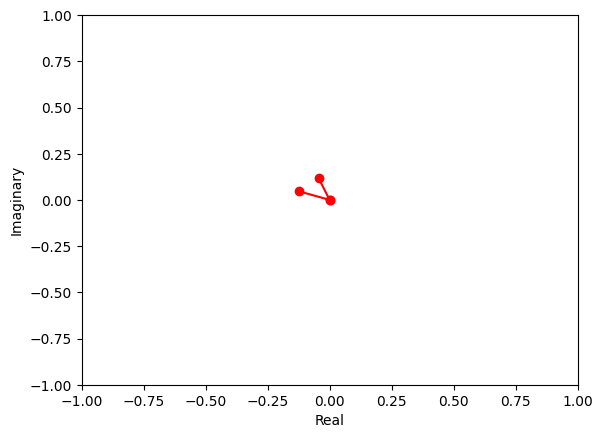

In [20]:
def argand(a):
    for x in range(len(a)):
        plt.plot([0,a[x].real],[0,a[x].imag],'ro-',label='python')
    limit=np.max(np.ceil(np.absolute(a))) # set limits for axis
    plt.xlim((-limit,limit))
    plt.ylim((-limit,limit))
    plt.ylabel('Imaginary')
    plt.xlabel('Real')
    plt.show()
z = [gt, pred]
argand(z)

In [ ]:
import numpy as np
10*np.log10(0.1)

In [ ]:
1680.4807/644.7053

In [ ]:
# normalized = (db_value - db_min) / (db_max - db_min)
# score = 1.0 - normalized
# score = max(0.0, min(1.0, score))

In [ ]:
print(evaluate_model(model, val_loader))

In [ ]:
channels = dataset.compute_channels()

In [ ]:
channels[1].max()


--- Ground Truth Length 25 

--- Model Predict Length (first 2.2543234825134277 paths) ---
tensor([[ 0.5065, -1.2801, -2.5249],
        [ 0.5010, -1.3082,  1.9324],
        [ 0.5482, -1.3265, -0.7685],
        [ 0.5554, -1.3326, -2.5359],
        [ 0.5310, -1.3465,  0.8344],
        [ 0.5144, -1.3684, -2.5719],
        [ 0.5035, -1.3689,  1.1262],
        [ 0.5181, -1.3718, -1.3977],
        [ 0.4859, -1.3722, -2.5135],
        [ 0.5074, -1.3733, -1.9612],
        [ 0.5089, -1.3754, -3.0642],
        [ 0.5359, -1.3800,  2.1249],
        [ 0.5028, -1.3847,  1.9733],
        [ 0.4915, -1.3848,  1.6532],
        [ 0.5347, -1.3857,  0.1389],
        [ 0.4634, -1.3987,  2.0965],
        [ 0.5624, -1.3991, -1.1121],
        [ 0.5030, -1.4048,  2.2440],
        [ 0.5673, -1.4173, -0.4851],
        [ 0.5294, -1.4277, -2.5969],
        [ 0.5731, -1.4409,  1.2203],
        [ 0.4882, -1.4411, -2.0299],
        [ 0.5737, -1.4415, -0.0611],
        [ 0.5370, -1.4440, -2.5392],
        [ 0.5715, -1

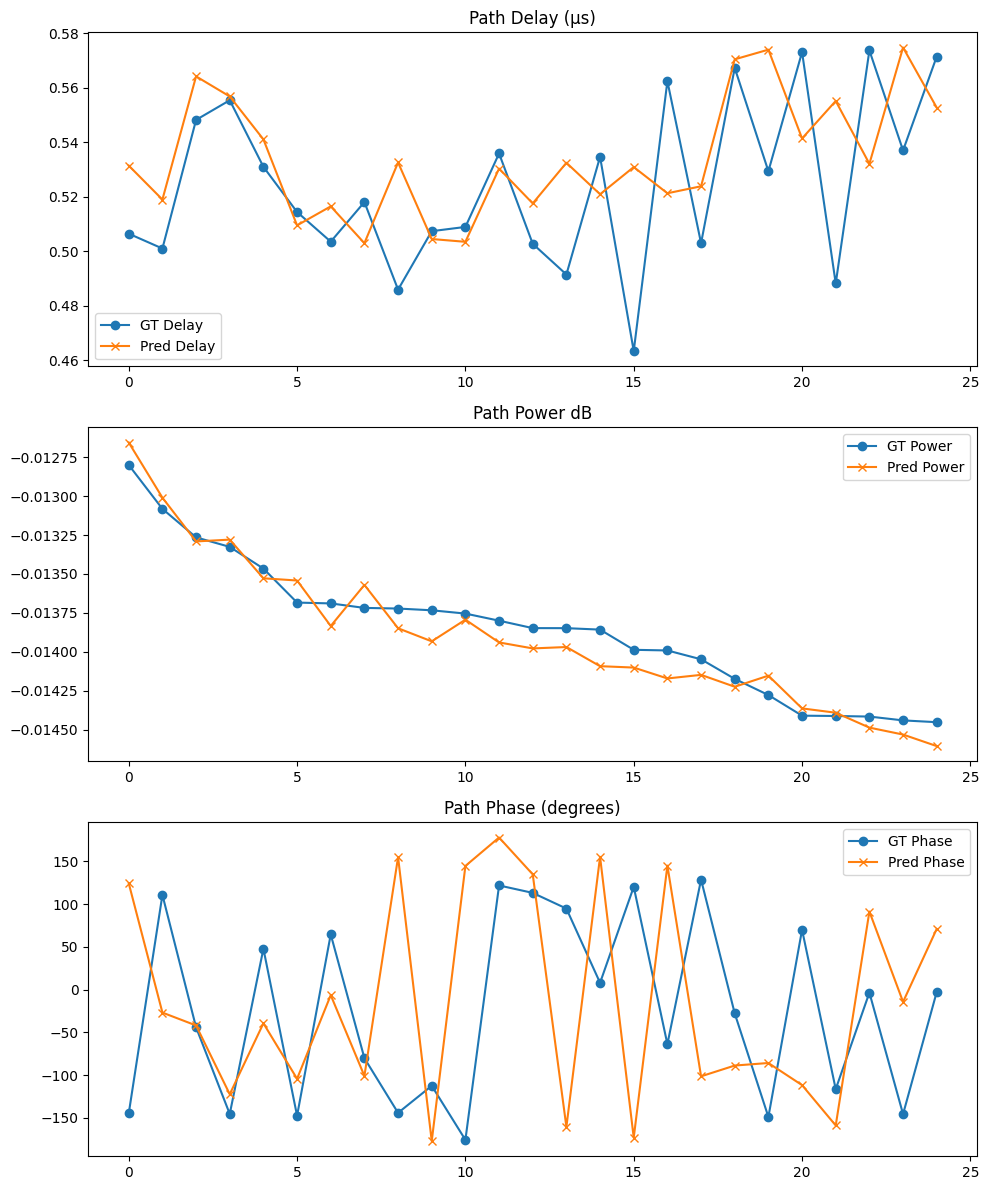

In [6]:
show_example(model, val_loader, 0, plot=True)